In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Create DataFrame from keyboard_actions.log

Log file is formatted as a csv file so pd.read_csv works like a charm

Indexed by timestamp of each action (should always be unique)

In [18]:
keyboard_df = pd.read_csv("logs/keyboard_actions.log", names=['time', 'key', 'action', 'class'])

keyboard_df

FileNotFoundError: [Errno 2] No such file or directory: 'logs/keyboard_actions.log'

### Create DataFrame from mouse_actions.log

same deal

In [ ]:
mouse_df = pd.read_csv("logs/mouse_actions.log", names=['time', 'x', 'y', 'button', 'action', 'class'])

mouse_df

,time,x,y,button,action,class
0,0.1377,506,403,left,released,Marco
1,0.3310,506,404,None,None,Marco
2,4.3988,577,428,None,None,Marco
3,4.4055,641,452,None,None,Marco
4,4.4124,701,476,None,None,Marco
...,...,...,...,...,...,...
241,9.4435,613,400,None,None,Marco
242,9.5405,612,400,None,None,Marco
243,9.5474,610,400,None,None,Marco
244,9.5677,608,400,None,None,Marco


## Generate heatmap from mouse positions

In [114]:
"""
MouseHeatmap class takes a segment of a dataframe generated from a
mouse_actions log file and provides methods to display it as a heatmap
showing the relative amount of time the mouse cursor spent in each location 
on the screen
"""
class MouseHeatmap:

    """
    Construct the heatmap object by passing it a pandas dataframe
    The dataframe must be generated from a mouse_actions log file
    You can obtain a specified slice of time from the dataframe using get_segment()
    """
    def __init__(self, df_segment):
        # Copy DataFrame as instance attribute
        self.df = df_segment

        # Initialize values used for building heatmap image
        self.last_time, self.last_x, self.last_y = 0, 0, 0

        # Screen dimensions according to log min/max values
        screen_w_log = np.max(self.df.x) - np.min(self.df.x)
        screen_h_log = np.max(self.df.y) - np.min(self.df.y)

        # Use 1080p dimesnions if larger log file dimensions
        self.screen_w, self.screen_h = max(1920, screen_w_log), max(1080, screen_h_log)

        # Saturation value used in normalization
        self.saturation = 5


    """
    Class method used for obtaining a specified segment from a DataFrame
    df: The original dataframe generated from a mouse_actions log file
    index: The index of the segment
    seg_length: The length of the segment (default 60)
    *Note* Segment length determines index, i.e. "The 5th 15-second segment"
    """
    @staticmethod
    def get_segment(df, index, seg_length=60):
        # Calculate first and last second of minute
        last_sec = index * seg_length
        first_sec = last_sec - seg_length

        # Create a mask for the specified time range
        mask = (df.time > first_sec) & (df.time < last_sec)

        # Return slice of dataframe within specified time frame
        return df[mask]

    
    """
    Utility method used to convert the instance's dataframe to a heatmap 
    of the specified resolution
    """
    def df_to_heatmap(self, res):
        # Initialize heatmap (with zeros)
        self.heatmap_values = np.zeros(res)
        self.heatmap_w, self.heatmap_h = res[0], res[1]

        # Reset last_time to signal the first line of data
        self.last_time = -1

        # Iterate through each row of dataframe segment
        for _, row in self.df.iterrows():
            line = row.values.tolist() # Convert row (pd.Series) to List
            self.line_to_heatmap(line) # Use list values to update heatmap image

        # Normalize heatmap values (divide by max value)
        self.heatmap_values /= max(np.max(self.heatmap_values), 1)

        # Compress the heatmap
        # Calculate max saturation = (mean / deviation) * (1 / saturation)
        threshold = self.heatmap_values.mean() / (max(self.heatmap_values.std(), 0.001) * self.saturation)
        # Anything above max_saturation is clamped to max_saturation
        self.heatmap_values[self.heatmap_values > threshold] = threshold

        # Transpose heatmap array to represent screenspace
        self.heatmap_values = self.heatmap_values.T


    """
    Utility method used to update the heatmap with a line of data
    - Add a line of data to the heatmap (in List form)
    - Uses the passed line to find duration that the mouse was in the last position
    - Adds previous line of data (from last function call) to heat map and prepares 
    the passed line for the next function call
    """
    def line_to_heatmap(self, line):
        
        # last_time is initialized to -1 to signal first line
        if self.last_time != -1:
            # Find duration of mouse in last position
            value = line[0] - self.last_time
            # Add last line of data to heatmap
            self.heatmap_values[self.last_x, self.last_y] += value

        # Prepare passed line of data for heatmap
        self.last_time = line[0]

        # Normalize and clamp data if needed
        x_raw, y_raw = line[1], line[2]
        x = int((x_raw / self.screen_w) * (self.heatmap_w - 1))
        y = int((y_raw / self.screen_h) * (self.heatmap_h - 1))
        if x < 0: x = 0
        if x > (self.heatmap_w - 1): x = self.heatmap_w - 1
        if y < 0: y = 0
        if y > (self.heatmap_h - 1): y = self.heatmap_h - 1
        self.last_x, self.last_y = x, y


    """
    Display the heatmap
    res: The resolution of the heatmap image
    """
    def show_heatmap(self, res=(100, 100)):
        # Convert DataFrame segment to np.ndarray in heatmap shape
        self.df_to_heatmap(res)

        # Show heatmap
        plt.figure(figsize=(7.5, 7.5))
        plt.imshow(self.heatmap_values, cmap='cividis')
        plt.tick_params(which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
        plt.show()

    """
    Display the heatmap centered in the image
    Uses the mean and variance of the data to find the center and scale
    """
    def show_heatmap_centered(self, res=(100, 100)):
        print("show_heatmap_centered() method is undergoing renovations")
        """
        # Find center values by averaging the indices of the max 10 column/row sums
        x_center = int(np.mean(np.argsort(heatmap.sum(axis=0))[::-1][:10]))
        y_center = int(np.mean(np.argsort(heatmap.sum(axis=1))[::-1][:10]))

        # Find variance by index of first non-zero value - index of last non-zero value
        # Then divide in half
        x_variance = int(np.trim_zeros(np.trim_zeros(heatmap.sum(axis=0), 'f'), 'b').size / 2)
        y_variance = int(np.trim_zeros(np.trim_zeros(heatmap.sum(axis=1), 'f'), 'b').size / 2)

        # Choose largest variance value (so heatmap is 1:1 ratio)
        variance = max(x_variance, y_variance)

        # Zoom in a little
        variance = int(variance * 0.8)

        x_min = max(x_center - variance, 0)
        x_max = x_center + variance
        y_min = max(y_center - variance, 0)
        y_max = y_center + variance

        MouseHeatmap.show_heatmap(heatmap[y_min:y_max, x_min:x_max])
        """


### Example usage of MouseHeatmap

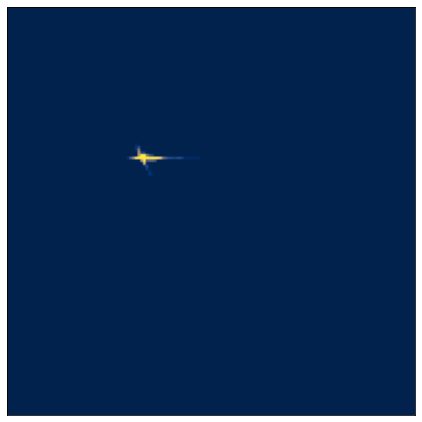

In [115]:
# Generate the dataframe from log file
mouse_df = pd.read_csv("logs/Zirui/Zirui_Mouse.log", names=['time', 'x', 'y', 'button', 'action', 'class'])

# Retrieve the 5th 30s segment from the dataframe
# MouseHeatmap has a class method for this
heatmap_segment = MouseHeatmap.get_segment(mouse_df, 5, seg_length=30)

# Use that segment to create the heatmap object
heatmap = MouseHeatmap(heatmap_segment)

# Show the segment as a 150x150 heatmap
heatmap.show_heatmap((150, 150))

## Generate heatmap from keyboard activities

In [2]:
#Keyboard log parser
class keyboardLogParser:
    @staticmethod
    def parseKeyboardLog(inputPath, outputPath, startMin, endMin):
        # The 49 default key bindings for team fortress 2
        keyBindings = ["w","a","s","d","Key.space","Key.ctrl_l","'","/","Key.up","Key.down",
                    "v","y","u","z","x","c",",",".","m","n","Key.f2","Key.f3","l","g",
                    "h","i","f","b","-","r","q","1","2","3","4","5","6","7","8","9","0",
                    "t","Key.tab","Key.f5","Key.f6","Key.f7","`","j","k"]
        #starMin and endMin must >= 0
        resultDict = {} # containing 'key':[last press time, last action, total duration, freq]
        start = float(startMin * 60)
        end = float(endMin * 60)

        # ReadFile
        file1 = open(inputPath, 'r')
        lines = file1.readlines()
        #Calculate duration and freq for each key between startMin and endMin
        for line in lines:
            line = line.replace("'", "")
            line = line.strip()
            words = line.split(",")
            time = float(words[0])
            key = words[1]
            if key in keyBindings:
                time = float(words[0])
                if time <= end:
                    if time >= start:
                        action = words[2]
                        if key in resultDict:
                            if resultDict[key][1] == "pressed":
                                if action == "released":
                                    newDura = time - resultDict[key][0]
                                    resultDict[key][2] += newDura
                                    resultDict[key][1] = action
                                    resultDict[key][3] += 1
                            else:
                                    if action == "pressed":
                                        resultDict[key][0] = time
                                        resultDict[key][1] = action
                        else:
                            if action == "pressed":
                                resultDict[key] = [time,action,0,0]
                else:
                    break

        #Write result to output file
        file2 = open(outputPath,'w')

        for key in resultDict:
            totalDura = resultDict[key][2]
            freq = resultDict[key][3]
            avgDura = totalDura/freq
            output = key +" "+ str("{:.5f}".format(avgDura)) +" "+ str(freq)
            print(output, file=file2)

In [3]:
class keyboardHeatmap:
    def __init__(self, keyboard_df, maxF, maxD):
        # The 49 default key bindings for team fortress 2
        self.keyBindings = ["w","a","s","d","Key.space","Key.ctrl_l","'","/","Key.up","Key.down",
                    "v","y","u","z","x","c",",",".","m","n","Key.f2","Key.f3","l","g",
                    "h","i","f","b","-","r","q","1","2","3","4","5","6","7","8","9","0",
                    "t","Key.tab","Key.f5","Key.f6","Key.f7","`","j","k"]
        keyFreqDict ={}
        keyDuraDict = {}
        self.maxFreq = maxF
        self.maxDura = maxD
        for key in self.keyBindings:
            keyFreqDict[key] = 0
            keyDuraDict[key] = 0
        theKeyboardDict = keyboard_df.to_dict('records')
        for item in theKeyboardDict:
            keyFreqDict[item['key']] = item['freq']
            keyDuraDict[item['key']] = item['avg_duration']
        self.keyFreqList = []
        self.keyDuraList = []
        for item in self.keyBindings:
            if item in keyFreqDict:
                self.keyFreqList.append(keyFreqDict[item])
            else:
                self.keyFreqList.append(0)
            if item in keyDuraDict:
                self.keyDuraList.append(keyDuraDict[item])
            else:
                self.keyDuraList.append(0)
        self.arrFreq = np.array([self.keyFreqList])
        self.arrDura = np.array([self.keyDuraList])

    @staticmethod
    def show_heatmap(heatmap):
        # Setting up the heatmap
        fig, axes = plt.subplots( nrows=2)
        ax1,ax2 = axes
        im1 = ax1.imshow(heatmap.arrFreq, cmap='cividis', vmax=heatmap.maxFreq)
        im2 = ax2.imshow(heatmap.arrDura, cmap='cividis', vmax=heatmap.maxDura)
        plt.subplots_adjust(top=0.1, bottom=0)


        ax1.set_xticks(np.arange(len(heatmap.keyBindings)))
        ax1.set_yticks(np.arange(len(['Frequency'])))
        ax2.set_xticks(np.arange(len(heatmap.keyBindings)))
        ax2.set_yticks(np.arange(len(['Average Duraion'])))

        ax1.set_xticklabels(heatmap.keyBindings)
        ax1.set_yticklabels(['Frequency'])
        ax2.set_xticklabels(heatmap.keyBindings)
        ax2.set_yticklabels(['Average Duraion'])
        # Rotate the tick labels and set their alignment.
        plt.setp(ax1.get_xticklabels(), rotation=20, ha="right")
        plt.setp(ax2.get_xticklabels(), rotation=20, ha="right")
        for i in range(len(heatmap.keyBindings)):
            text = ax1.text(i,0, heatmap.keyFreqList[i], ha='center')
            text = ax2.text(i,0, heatmap.keyDuraList[i], ha='center')
        ax1.set_title("Frequency")
        ax2.set_title("Average Duration")
        fig.set_size_inches(40,30)
        fig.suptitle("Frequency and average duartion pressed for keys", fontsize=16, ha='center', va='top', x=0.5, y= 0.12)
        fig.tight_layout

        # Show heatmaps for frequency and average duartion pressed for keys
        plt.show()

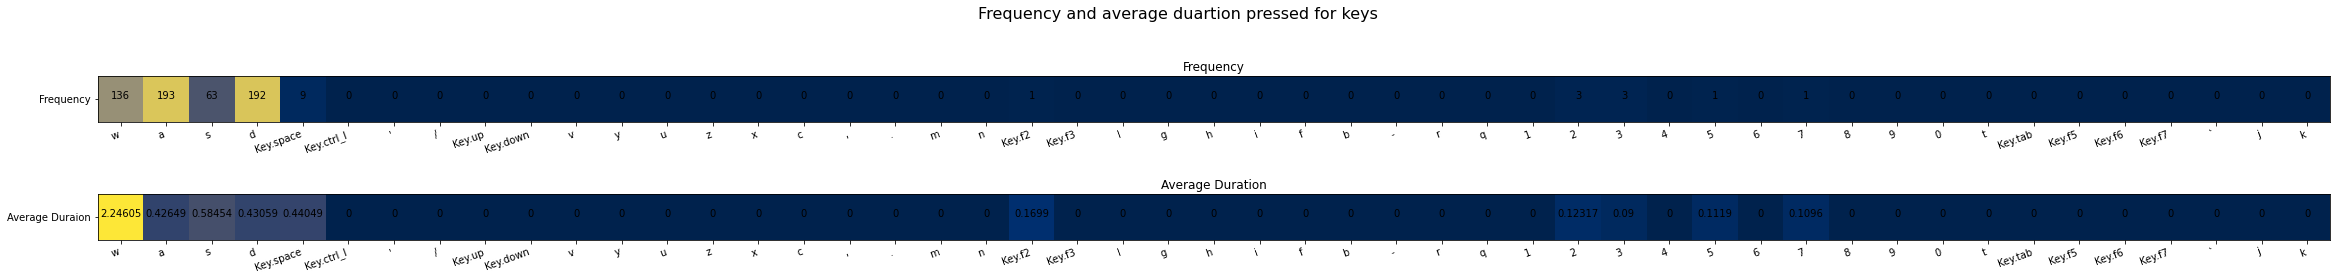

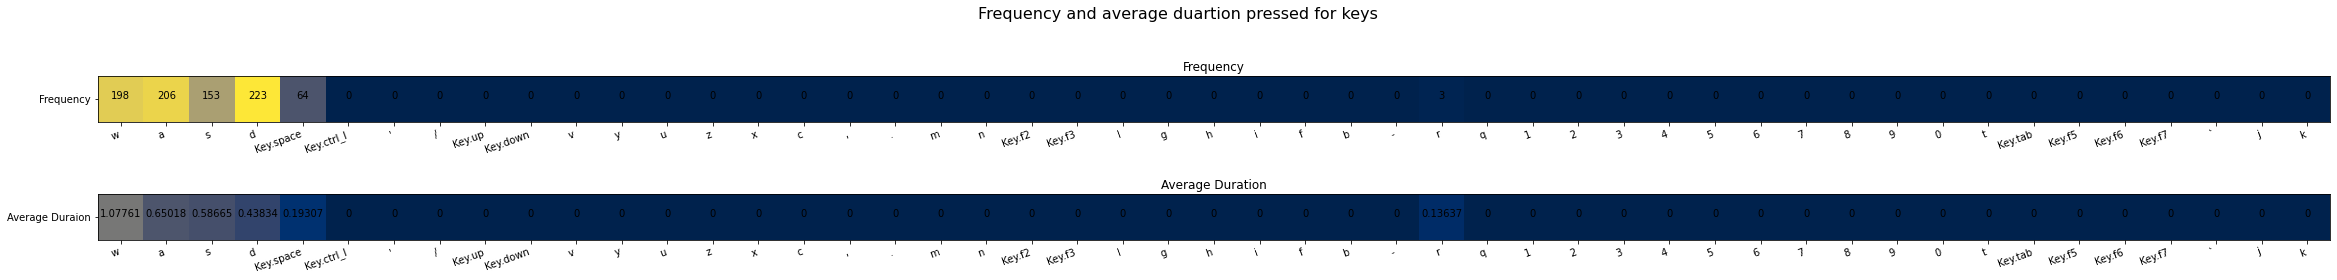

In [4]:
# Getting the data from  parsed input keyboard log file
#                 parseKeyboardLog(inputPath, outputPath, startMin, endMin):
keyboardLogParser.parseKeyboardLog("keyboard_actions_jon_spy_nov8.log","JonFreqDura.log",0,10)
keyboardLogParser.parseKeyboardLog("Zirui_Keyboard.log","ZiruiFreqDura.log",0,10)
Jon_keyboardDurationAndFreq_df = pd.read_csv("JonFreqDura.log",delimiter=" ", names=['key', 'avg_duration', 'freq'])
Zirui_keyboardDurationAndFreq_df = pd.read_csv("ZiruiFreqDura.log",delimiter=" ", names=['key', 'avg_duration', 'freq'])
#Need to calculate max vlaue for color bar before showing heatmap
keyboardInputList = []
keyboardInputList.append(Jon_keyboardDurationAndFreq_df)
keyboardInputList.append(Zirui_keyboardDurationAndFreq_df)
maxFreq = 0
maxDura = 0
for keyboardInput in keyboardInputList:
    maxF = np.max(keyboardInput.freq)
    maxD = np.max(keyboardInput.avg_duration)
    if maxF > maxFreq:
        maxFreq = maxF
    if maxD > maxDura:
        maxDura = maxD
keyboadrheatmapJon = keyboardHeatmap(Jon_keyboardDurationAndFreq_df,maxFreq,maxDura)
keyboadrheatmapZirui = keyboardHeatmap(Zirui_keyboardDurationAndFreq_df,maxFreq,maxDura)
keyboardHeatmap.show_heatmap(keyboadrheatmapJon)
keyboardHeatmap.show_heatmap(keyboadrheatmapZirui)